<a href="https://colab.research.google.com/github/Noufal21/cat-vs-dog-classification-CNN-/blob/master/Cat_vs_Dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install kaggle --upgrade

In [3]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
api_token = {"username":"d3xter271","key":"2321f0dfe4d3d8782b5bb1624e50f73c"}
import json
import zipfile
import os
!chmod 600 /root
!kaggle config path -p /content
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle competitions download -c dogs-vs-cats
os.chdir('/content/')


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
100% 271M/271M [00:03<00:00, 71.3MB/s]

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 90.1MB/s]
 97% 529M/543M [00:07<00:00, 85.3MB/s]
100% 543M/543M [00:07<00:00, 77.1MB/s]


In [27]:
import pandas as pd
import numpy as np

import os
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import  Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D
from keras import backend as K

from matplotlib import pyplot
from matplotlib import cm
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

In [5]:
IMAGE_WIDTH = 250
IMAGE_CHANNEL = 3
IMAGE_SIZE = (IMAGE_WIDTH,IMAGE_WIDTH)
BATCH_SIZE = 64

In [6]:
from zipfile import ZipFile
with ZipFile('/content/test1.zip', 'r') as zipObj:
    print(zipObj)
    zipObj.extractall("data")

<zipfile.ZipFile filename='/content/test1.zip' mode='r'>


In [7]:
from zipfile import ZipFile
with ZipFile('/content/train.zip', 'r') as zipObj:
    print(zipObj)
    zipObj.extractall("data")

<zipfile.ZipFile filename='/content/train.zip' mode='r'>


In [29]:
filenames = os.listdir("/content/data/train")

cat = []
images = []
path = "/content/data/train/"
for file in filenames:
  classType = file.split('.')[0]
  image = Image.open(path + file)
  image = image.resize(IMAGE_SIZE)
  image = np.array(image)
  images.append(image)
  if classType == "dog":
    cat.append(0)
  else:
    cat.append(1)


trainData = pd.DataFrame({"fileName" : filenames, 'categories' : cat, 'Images' : images})


In [42]:
cat = np.array(cat)
images = np.array(images)

In [ ]:
trainData.head()

In [31]:
trainData["categories"] = trainData["categories"].replace({0: 'dog', 1: 'cat'}) 

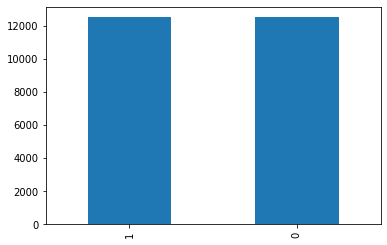

In [34]:
trainData["categories"].value_counts().plot(kind = "bar")

In [33]:
trainData["categories"] = trainData["categories"].replace({ 'dog': 0,  'cat' : 1}) 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(images,cat, test_size=0.20, random_state=20)

In [17]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/data/train/", 
    x_col='fileName',
    y_col='categories',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE 
)

Found 20000 validated image filenames belonging to 2 classes.


In [13]:
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/data/train/", 
    x_col='fileName',
    y_col='categories',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


In [66]:
def createModel( num_classes,input_shape):
  model = Sequential()
  model.add(Conv2D(16,kernel_size=(3,3),activation= "relu",input_shape = input_shape))
  model.add(Conv2D(16,kernel_size=(3,3),activation= "relu"))  
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2))) 
  model.add(Dropout(0.15))


  model.add(Conv2D(32,kernel_size=(3,3),activation= "relu"))
  model.add(Conv2D(32,kernel_size=(3,3),activation= "relu"))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.15))

  model.add(Conv2D(64,kernel_size=(3,3),activation= "relu"))
  model.add(Conv2D(64,kernel_size=(3,3),activation= "relu"))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.15))


  model.add(Conv2D(128,kernel_size=(3,3),activation= "relu"))
  model.add(Conv2D(128,kernel_size=(3,3),activation= "relu"))
  model.add(Conv2D(128,kernel_size=(3,3),activation= "relu"))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.15))

  model.add(Conv2D(256,kernel_size=(3,3),activation= "relu"))
  model.add(Conv2D(256,kernel_size=(3,3),activation= "relu"))
  model.add(Conv2D(256,kernel_size=(3,3),activation= "relu"))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.15))

  model.add(Flatten())
  model.add(Dense(1024,activation= 'relu'))
  model.add(Dropout(0.15))
  model.add(Dense(100,activation= 'relu'))
  model.add(Dropout(0.15))

  model.add(Dense(num_classes,activation='softmax'))
  model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(learning_rate= 0.0003),metrics = ['accuracy'])

  return model
batch_size = 128
num_classes = 2
input_shape = (IMAGE_WIDTH,IMAGE_WIDTH,IMAGE_CHANNEL)
model = createModel(num_classes,input_shape)

In [45]:
b = np.zeros((y_train.size, y_train.max()+1))
b[np.arange(y_train.size),y_train] = 1

In [46]:
c = np.zeros((y_test.size, y_test.max()+1))
c[np.arange(y_test.size),y_test] = 1

In [56]:
X_test.shape

(5000, 250, 250, 3)

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model,show_shapes= True,show_layer_names=True)

In [49]:
earlyStop = EarlyStopping(patience = 10)

variable_gradient = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.00001)

In [68]:
epochs = 20
hist = model.fit(
    X_train,b, 
    epochs=epochs,
    validation_data=(X_test,c),
    callbacks=[earlyStop,variable_gradient],
    batch_size=BATCH_SIZE
)

Epoch 1/20
313/313 [==============================] - 20s 62ms/step - loss: 0.6131 - accuracy: 0.6694 - val_loss: 0.7516 - val_accuracy: 0.5560
Epoch 2/20
313/313 [==============================] - 19s 62ms/step - loss: 0.5062 - accuracy: 0.7569 - val_loss: 0.5386 - val_accuracy: 0.7616
Epoch 3/20
313/313 [==============================] - 19s 62ms/step - loss: 0.4171 - accuracy: 0.8137 - val_loss: 0.4237 - val_accuracy: 0.8074
Epoch 4/20
313/313 [==============================] - 19s 62ms/step - loss: 0.3441 - accuracy: 0.8493 - val_loss: 0.3889 - val_accuracy: 0.8312
Epoch 5/20
313/313 [==============================] - 19s 62ms/step - loss: 0.2855 - accuracy: 0.8814 - val_loss: 0.3730 - val_accuracy: 0.8322
Epoch 6/20
313/313 [==============================] - 19s 62ms/step - loss: 0.2499 - accuracy: 0.8935 - val_loss: 0.3020 - val_accuracy: 0.8706
Epoch 7/20
313/313 [==============================] - 19s 62ms/step - loss: 0.2226 - accuracy: 0.9069 - val_loss: 0.2342 - val_accuracy:

In [ ]:
model.save('dogvscat.h5')
from google.colab import files
files.download('dogvscat.h5')

In [70]:
predIdxs = model.predict_classes(X_test)



In [74]:

print(classification_report(y_test ,predIdxs,target_names={'dog',"cat"}))

              precision    recall  f1-score   support

         cat       0.93      0.96      0.94      2505
         dog       0.95      0.93      0.94      2495

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



In [77]:
test_filenames = os.listdir("/content/data/test1")
test_df = pd.DataFrame({
    'filenames': test_filenames
})
path = "/content/data/test1/"
newData = []
for file in test_filenames:
  image = Image.open(path + file)
  image = image.resize(IMAGE_SIZE)
  image = np.array(image)
  newData.append(image)

newData = np.array(newData)

In [80]:
test_df.head()

,filenames
0,6757.jpg
1,1597.jpg
2,1165.jpg
3,11032.jpg
4,7829.jpg


In [81]:
pred = model.predict_classes(newData)
test_df['categories'] = pred


In [84]:
test_df["categories"] = test_df["categories"].replace({ 0: 'dog',  1: 'cat' }) 

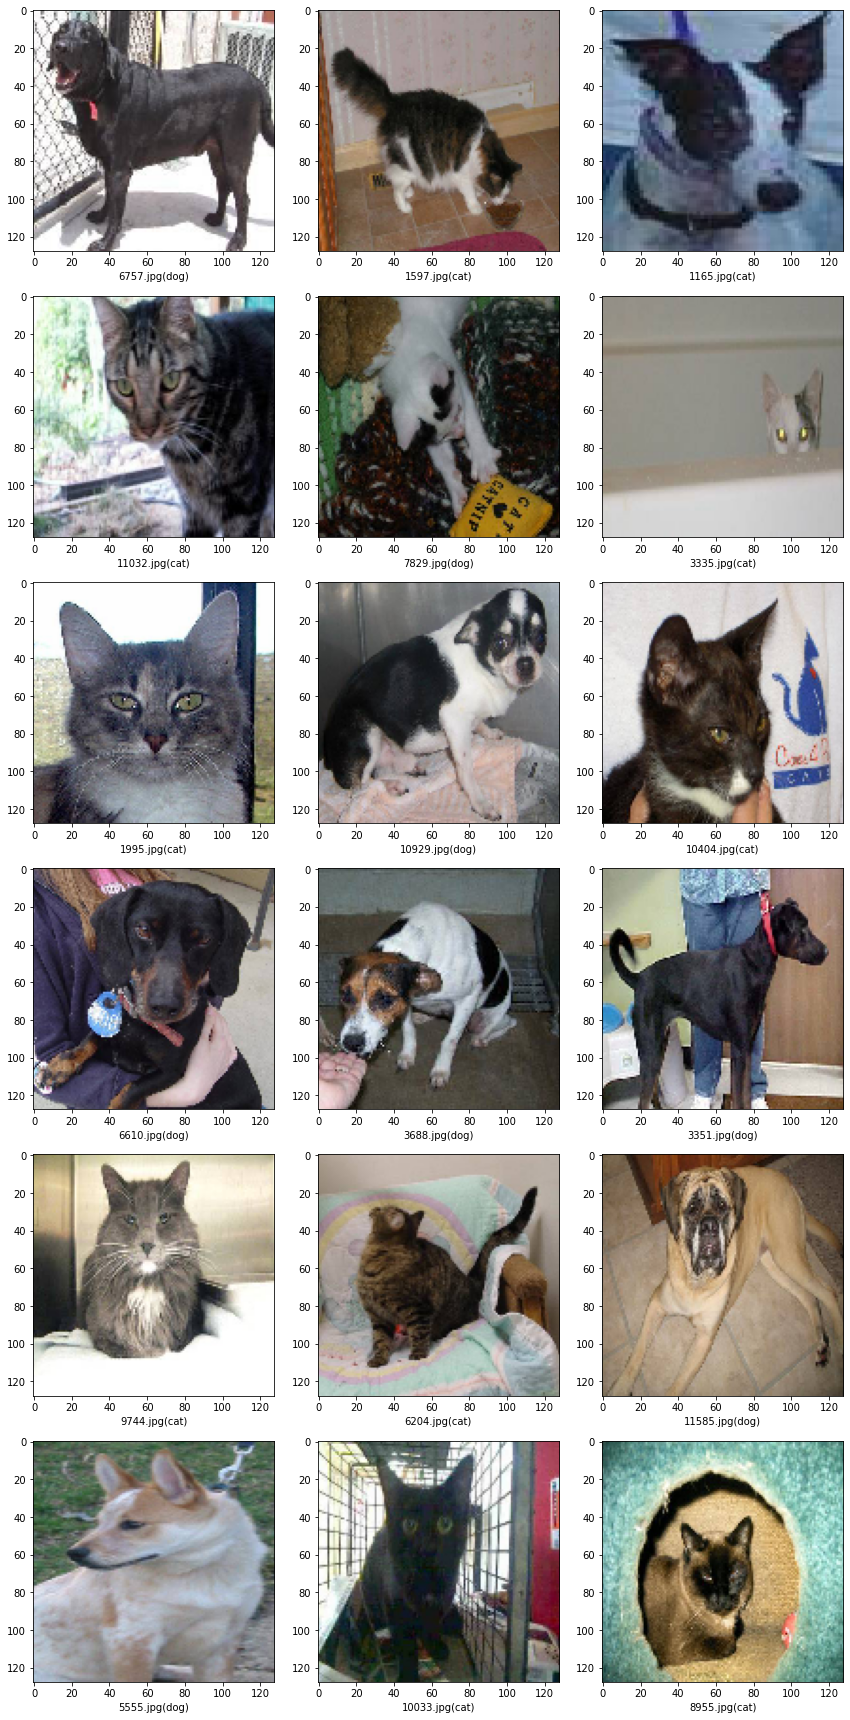

In [85]:
sample_test = test_df.head(18)
sample_test.head()
pyplot.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filenames']
    category = row['categories']
    img = load_img("/content/data/test1/"+filename, target_size=(128,128))
    pyplot.subplot(6, 3, index+1)
    pyplot.imshow(img)
    pyplot.xlabel(filename + '(' + "{}".format(category) + ')' )
pyplot.tight_layout()
pyplot.show()